### Retrieval augmented generation and inference

#### Installation:

In [ ]:
!pip install simpletransformers csrgraph networkx==2.8 evaluate accelerate

#### Imports:

In [1]:
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from graph_utils import *
from tree_utils import *
from gpt import GPT
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
from itertools import combinations
import networkx as nx
import random
import pickle
import gc

random.seed(42)

In [ ]:
from simpletransformers.language_modeling import (
    LanguageModelingModel,
    LanguageModelingArgs,
)
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

### Test trained models

In [ ]:
def reformat_fn(relationships, entities):    
    relationships_dict = {}
    for source_idx, relation, target_idx in relationships:
        source = entities[source_idx]
        target = entities[target_idx]
        if source not in relationships_dict:
            relationships_dict[source] = {}
        if relation not in relationships_dict[source]:
            relationships_dict[source][relation] = []
        relationships_dict[source][relation].append(target)
    return relationships_dict

In [ ]:
def prep_data(relationships):
    entities = [generate_name() for j in range(4)]
    
    test_rel = relationships[random.randrange(0, len(relationships))]
    test_seq = f'{entities[test_rel[0]]} {test_rel[1]} {entities[test_rel[2]]}'

    relationships = [r for r in relationships if r != test_rel]
    
    relationships_dict = reformat_fn(relationships, entities)
    
    G = create_family_tree_digraph(relationships_dict)
    seqs_to_encode = generate_random_walks(G, n=1, walk_length=25)
    
    return test_seq, seqs_to_encode

def retrieve_fn(query, hpc):
    return [s for s in hpc if query[0:2] in s]

In [ ]:
def extract_nodes_from_seq(seq):
    keywords = ['NORTH', 'SOUTH', 'EAST', 'WEST', 'SIBLING_OF', 'SPOUSE_OF', 'PARENT_OF', 'CHILD_OF']
    # Split the sequence and filter out direction keywords
    nodes = [word for word in seq.split() if word not in keywords]
    return nodes

def check_nodes_in_hpc_sequences(seq_to_encode, hpc):
    # Check if any nodes from seq_to_encode appear in any of the hpc sequences.
    nodes = extract_nodes_from_seq(seq_to_encode)
    for hpc_seq in hpc:
        # Check if any node appears in the current hpc sequence
        if any(node in hpc_seq for node in nodes):
            return True  # At least one node found in the hpc sequences
    return False  # No nodes found in any of the hpc sequences


In [ ]:
data_to_plot = {
    'Spatial task': {},
    'Family tree task': {}
}

#### Test tree model

In [ ]:
relationships = [
    (0, "SPOUSE_OF", 1),  
    (1, "SPOUSE_OF", 0),
    (0, "PARENT_OF", 2),  
    (0, "PARENT_OF", 3),  
    (1, "PARENT_OF", 2),  
    (1, "PARENT_OF", 3),  
    (3, "SIBLING_OF", 2),
    (2, "SIBLING_OF", 3),
    (3, "CHILD_OF", 0), 
    (2, "CHILD_OF", 0),  
    (3, "CHILD_OF", 1),   
    (2, "CHILD_OF", 1)    
]

test_seqs = []
hpc = []

while len(test_seqs) < 100:
    test_seq, seqs_to_encode = prep_data(relationships)
    if check_nodes_in_hpc_sequences(seqs_to_encode[0], hpc) is False:
        test_seqs.append(test_seq)
        hpc.extend(seqs_to_encode)
    else:
        print("Skipping repeated nodes.")

In [ ]:
model = GPT(base_model='familygraph2', base_model_name='gpt2')

correct_count = 0

for i in range(100):

    test_seq = test_seqs[i]
    retrieved_seqs = retrieve_fn(test_seq, hpc)
    
    prompt = ' '.join(retrieved_seqs) + ' ' + test_seq[0:-3]
    out = model.continue_input(prompt, num_beams=5)
    print(out[0:len(prompt) + 3])
    print(out[len(prompt)+1:len(prompt)+3], test_seq[-2:])
    if out[len(prompt)+1:len(prompt)+3] == test_seq[-2:]:
        print("CORRECT")
        correct_count += 1
    print("---------------------")

In [ ]:
print(correct_count)

data_to_plot['Spatial task']['RAG'] = correct_count / 100

In [ ]:
model = GPT(base_model='family_graph', base_model_name='gpt2')

correct_count = 0

for i in range(100):

    test_seq = test_seqs[i]
    retrieved_seqs = retrieve_fn(test_seq, hpc)
    
    random_pred = random.choice(list(set(extract_nodes_from_seq(retrieved_seqs[0]))))
    if random_pred == test_seq[-2:]:
        correct_count += 1

In [ ]:
print(correct_count)

data_to_plot['Spatial task']['HPC only'] = correct_count / 100

#### Test spatial model

In [ ]:
relationships = [
    (0, "EAST", 1),  
    (1, "SOUTH", 2),  
    (2, "WEST", 3),  
    (3, "NORTH", 0),
    (1, "WEST", 0),  
    (2, "NORTH", 1),  
    (3, "EAST", 2),  
    (0, "SOUTH", 3)
]

test_seqs = []
hpc = []

while len(test_seqs) < 100:
    test_seq, seqs_to_encode = prep_data(relationships)
    if check_nodes_in_hpc_sequences(seqs_to_encode[0], hpc) is False:
        test_seqs.append(test_seq)
        hpc.extend(seqs_to_encode)
    else:
        print("Skipping repeated nodes.")

In [ ]:
model = GPT(base_model='../../models/spatial_graph', base_model_name='gpt2')

correct_count = 0

for i in range(100):

    test_seq = test_seqs[i]
    retrieved_seqs = retrieve_fn(test_seq, hpc)
    
    prompt = ' '.join(retrieved_seqs) + ' ' + test_seq[0:-3]
    out = model.continue_input(prompt, num_beams=5)
    print(out[0:len(prompt) + 3])
    print(out[len(prompt)+1:len(prompt)+3], test_seq[-2:])
    if out[len(prompt)+1:len(prompt)+3] == test_seq[-2:]:
        print("CORRECT")
        correct_count += 1
    print("---------------------")

In [ ]:
print(correct_count)

data_to_plot['Spatial task']['RAG'] = correct_count / 100

In [ ]:
model = GPT(base_model='../../models/spatial_graph', base_model_name='gpt2')

correct_count = 0

for i in range(100):

    test_seq = test_seqs[i]
    retrieved_seqs = retrieve_fn(test_seq, hpc)
    
    random_pred = random.choice(list(set(extract_nodes_from_seq(retrieved_seqs[0]))))
    if random_pred == test_seq[-2:]:
        correct_count += 1

In [ ]:
print(correct_count)

data_to_plot['Spatial task']['HPC only'] = correct_count / 100

#### Plot results

Uncomment to regenerate thesis results:

In [ ]:
data_to_plot = {
    'Spatial task': {'RAG': 0.9, 'HPC only': 0.28, 'NC only': 0.00},
    'Family tree task': {'RAG': 0.62, 'HPC only': 0.23, 'NC only': 0.00}
}

In [ ]:
# Prepare data for plotting
categories = list(data_to_plot.keys())  # ['spatial', 'family']
methods = list(data_to_plot['Spatial task'].keys())  # ['RAG', 'HPC only', 'NC only']
n_categories = len(categories)
n_methods = len(methods)

# Create figure and axes
fig, ax = plt.subplots(figsize=(5,3))

# Set the positions and width for the bars
positions = np.arange(n_categories)
bar_width = 0.25

# Plot data and annotate
for i, method in enumerate(methods):
    scores = [data_to_plot[category][method] for category in categories]
    bars = ax.bar(positions + i*bar_width, scores, bar_width, label=method, alpha=0.5)
    # Annotate each bar within this group
    for bar, score in zip(bars, scores):
        ax.annotate('{}'.format(score),
                    xy=(bar.get_x() + bar.get_width() / 2, score),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Formatting
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1)
ax.set_xticks(positions + bar_width)
ax.set_xticklabels(categories)
ax.legend()

# Show plot
plt.tight_layout()
plt.savefig('RAG_graph.png', dpi=300)
plt.show()


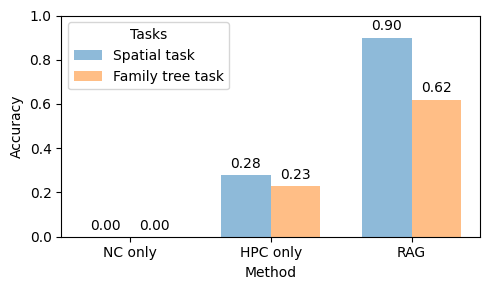

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
data_to_plot = {
    'Spatial task': {'RAG': 0.9, 'HPC only': 0.28, 'NC only': 0.00},
    'Family tree task': {'RAG': 0.62, 'HPC only': 0.23, 'NC only': 0.00}
}

# Specifying the order explicitly
methods = ['NC only', 'HPC only', 'RAG']  # This order will be used in the x-axis
tasks = list(data_to_plot.keys())  # ['Spatial task', 'Family tree task']

n_methods = len(methods)
n_tasks = len(tasks)

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 3))  # Adjusted size for clarity

# Set the positions and width for the bars
positions = np.arange(n_methods)
bar_width = 0.35  # Adjust bar width for better visual separation

# Plot data and annotate
for i, task in enumerate(tasks):
    scores = [data_to_plot[task][method] for method in methods]
    bars = ax.bar(positions + i * bar_width, scores, bar_width, label=task, alpha=0.5) 
    for bar, score in zip(bars, scores):
        ax.annotate('{:.2f}'.format(score),  # Formatting to two decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, score),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Formatting
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)  # Ensure y-axis starts at 0 and ends at 1 for better comparison
ax.set_xticks(positions + bar_width / 2)  # Adjust tick position to be in the middle of the grouped bars
ax.set_xticklabels(methods)
ax.legend(title="Tasks")

# Show plot
plt.tight_layout()
plt.savefig('RAG_graph_by_method_inf.png', dpi=300)
plt.show()
